# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import shap
from sklearn.svm import SVR
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing

os.environ["KERAS_BACKEND"] = "jax"

from keras import Sequential
from keras.src.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from pmdarima.arima import auto_arima
from pyESN import ESN
from shap.plots import colors
from sklearn.ensemble import RandomForestRegressor as RandomForest
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from statsmodels.tsa.api import SimpleExpSmoothing
from xgboost import XGBRegressor

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)


reset_seed()


def rrmse(actual, predicted) -> int:
    return root_mean_squared_error(actual, predicted) / np.mean(actual)


def smape(actual, predicted) -> int:
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)

    return round(
        np.mean(
            np.abs(predicted - actual) /
            ((np.abs(predicted) + np.abs(actual)) / 2)
        ) * 100, 2
    )



2024-09-17 12:05:32.577612: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-17 12:05:32.632266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 12:05:32.632301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 12:05:32.633815: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 12:05:32.642952: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-17 12:05:32.645075: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Load Datasets



In [2]:
df = pd.read_csv('dataset - Coronel/elect_merged_selected.csv', sep=";", decimal=",", header=0)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df = df[df["date"] >= '2019-01-01']
df = df[df["date"] <= '2023-12-31']

df.set_index("date", inplace=True)

df = df.astype("float32")

x = df.drop("consumption", axis=1)
y = df["consumption"]

df

,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_06,LAG_12,maxtemp_mean_abs,mintemp_abs,windmaxvel_abs,month_MAR,year_2019
date,,,,,,,,,,,,
2019-01-31,2235.0,0.000000,2416.0,2349.0,2283.0,1863.0,1452.0,36.000000,17.9,8.9,0.0,1.0
2019-02-28,2611.0,0.000000,2235.0,2416.0,2349.0,2700.0,2110.0,35.700001,14.1,7.6,0.0,1.0
2019-03-31,2328.0,0.000000,2611.0,2235.0,2416.0,2079.0,3361.0,33.500000,13.7,8.3,1.0,1.0
2019-04-30,2482.0,0.000000,2328.0,2611.0,2235.0,2283.0,2721.0,32.200001,11.5,6.9,0.0,1.0
2019-05-31,2464.0,0.000000,2482.0,2328.0,2611.0,2349.0,2334.0,32.099998,9.2,8.7,0.0,1.0
2019-06-30,2153.0,0.000000,2464.0,2482.0,2328.0,2416.0,2264.0,29.400000,7.0,7.6,0.0,1.0
2019-07-31,1929.0,0.000000,2153.0,2464.0,2482.0,2235.0,1863.0,29.100000,-3.2,6.7,0.0,1.0
2019-08-31,2139.0,0.000000,1929.0,2153.0,2464.0,2611.0,2700.0,31.100000,-0.7,7.8,0.0,1.0
2019-09-30,2097.0,0.000000,2139.0,1929.0,2153.0,2328.0,2079.0,34.700001,7.7,9.4,0.0,1.0


# Best Params

In [3]:
best = {}
for model in ["CNN", "ESN", "LSTM", "RF", "SVR", "XGB"]:
    df_aux = pd.DataFrame()
    for optimizer in ["GA", "PSO"]:
        for seed, name in [("1000", "A"), ("2000", "B"), ("3000", "C")]:
            try:
                new_df = pd.read_csv(f'params/{optimizer}-{model} ITERS SEED {seed}.csv', sep=";", decimal=",",
                                     header=0)
                df_aux = pd.concat([df_aux, new_df], axis=0)
            except Exception as e:
                continue

    df_aux = df_aux.sort_values(by=["Fitness"])
    df_aux[df_aux.isnull()] = None
    best[f"{model}"] = df_aux[:1].iloc[0].to_dict()

# Prediction
## Model Instantiation

In [4]:
#LSTM
tf.keras.backend.clear_session()
lstm = Sequential([
    Input((x.shape[1], 1)),
    LSTM(best["LSTM"]["Units"],
         activation=best["LSTM"]["Activation"],
         use_bias=best["LSTM"]["Bias"],
         seed=SEED),
    Dense(1),
])
lstm.compile(loss='mse')

#RF
rf = RandomForest(random_state=SEED,
                  n_estimators=int(best["RF"]["N_estimators"]),
                  max_depth=int(best["RF"]["Max_depth"]),
                  min_samples_split=int(best["RF"]["Min_samples_split"]),
                  min_samples_leaf=int(best["RF"]["Min_samples_leaf"]))

#SVR
svr = SVR(C=best["SVR"]["C"],
          epsilon=best["SVR"]["Epsilon"],
          kernel=best["SVR"]["Kernel"])

#XGB
updater = "coord_descent" if best["XGB"]["Booster"] == "gblinear" else None
xgb = XGBRegressor(random_state=SEED,
                   n_estimators=int(best["XGB"]["N_estimators"]),
                   max_depth=int(best["XGB"]["Max_depth"]),
                   booster=best["XGB"]["Booster"],
                   reg_lambda=best["XGB"]["Lambda"],
                   reg_alpha=best["XGB"]["Alpha"],
                   updater=updater)

#CNN
tf.keras.backend.clear_session()
cnn = Sequential([
    Input((x.shape[1], 1)),
    Conv1D(filters=best["CNN"]["Filters"],
           kernel_size=2,
           activation=best["CNN"]["Activation"]),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(best["CNN"]["Dense"], activation=best["CNN"]["Activation"]),
    Dense(1),
])
cnn.compile(loss='mse')

#ESN
esn = ESN(n_inputs=x.shape[1],
          n_outputs=1,
          n_reservoir=int(best["ESN"]["Reservoirs"]),
          sparsity=best["ESN"]["Sparsity"],
          spectral_radius=best["ESN"]["Spectral Radius"],
          noise=best["ESN"]["Noise"],
          random_state=SEED)

2024-09-17 12:05:38.167084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 12:05:38.168744: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Train Split

In [5]:
reset_seed()
N_SPLITS = 5
H = 12
W = 0.0833
i = 1

preds_cnn = []
preds_esn = []
preds_lstm = []
preds_rf = []
preds_svr = []
preds_xgb = []

scores_cnn = []
scores_esn = []
scores_lstm = []
scores_rf = []
scores_svr = []
scores_xgb = []

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=H, shuffle=False)
for i_train, i_test in TimeSeriesSplit(n_splits=N_SPLITS, test_size=1).split(x_train, y_train):
    reset_seed()
    kx_train, kx_test = x_train.iloc[i_train].to_numpy(), x_train.iloc[i_test].to_numpy()
    ky_train, ky_test = y_train.iloc[i_train].to_numpy(), y_train.iloc[i_test].to_numpy()

    cnn.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=best["CNN"]["Epochs"])
    tf.keras.backend.clear_session()
    esn.fit(kx_train, ky_train)
    tf.keras.backend.clear_session()
    lstm.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
             batch_size=best["LSTM"]["Batch Size"])
    rf.fit(kx_train, ky_train)
    svr.fit(kx_train, ky_train)
    xgb.fit(kx_train, ky_train)

    pred_cnn = int(cnn.predict(kx_test)[0][0])
    pred_esn = int(esn.predict(kx_test)[0])
    pred_lstm = int(lstm.predict(kx_test)[0][0])
    pred_rf = int(rf.predict(kx_test)[0])
    pred_svr = int(svr.predict(kx_test)[0])
    pred_xgb = int(xgb.predict(kx_test)[0])

    preds_cnn.append(pred_cnn)
    preds_esn.append(pred_esn)
    preds_lstm.append(pred_lstm)
    preds_rf.append(pred_rf)
    preds_svr.append(pred_svr)
    preds_xgb.append(pred_xgb)

    scores_cnn.append(mean_absolute_error(ky_test, [pred_cnn]))
    scores_esn.append(mean_absolute_error(ky_test, [pred_esn]))
    scores_lstm.append(mean_absolute_error(ky_test, [pred_lstm]))
    scores_rf.append(mean_absolute_error(ky_test, [pred_rf]))
    scores_svr.append(mean_absolute_error(ky_test, [pred_svr]))
    scores_xgb.append(mean_absolute_error(ky_test, [pred_xgb]))

    i = i + 1

cnn.fit(x_train.to_numpy(), y_train.to_numpy(), shuffle=False, verbose=False, epochs=198)
lstm.fit(x_train.to_numpy(), y_train.to_numpy(), shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
         batch_size=best["LSTM"]["Batch Size"])
rf.fit(x_train.to_numpy(), y_train.to_numpy())
svr.fit(x_train.to_numpy(), y_train.to_numpy())
xgb.fit(x_train.to_numpy(), y_train.to_numpy())

df = pd.DataFrame({
    "CNN": pd.Series(scores_cnn),
    "ESN": pd.Series(scores_esn),
    "LSTM": pd.Series(scores_lstm),
    "RF": pd.Series(scores_rf),
    "SVR": pd.Series(scores_svr),
    "XGB": pd.Series(scores_xgb),
})
df.to_csv("results - Coronel 12m/scores.csv", sep=";", decimal=",", header=True)
display(df)

1/1 [==============================] - 0s 388ms/step


/tmp/ipykernel_44240/650456653.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_esn = int(esn.predict(kx_test)[0])


1/1 [==============================] - 0s 102ms/step


/tmp/ipykernel_44240/650456653.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_esn = int(esn.predict(kx_test)[0])


1/1 [==============================] - 0s 91ms/step


/tmp/ipykernel_44240/650456653.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_esn = int(esn.predict(kx_test)[0])


1/1 [==============================] - 0s 116ms/step


/tmp/ipykernel_44240/650456653.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_esn = int(esn.predict(kx_test)[0])


1/1 [==============================] - 0s 113ms/step


/tmp/ipykernel_44240/650456653.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_esn = int(esn.predict(kx_test)[0])


,CNN,ESN,LSTM,RF,SVR,XGB
0,839.0,317.0,217.0,824.0,1528.0,672.0
1,1145.0,291.0,19.0,648.0,1590.0,507.0
2,649.0,273.0,451.0,30.0,790.0,119.0
3,427.0,95.0,653.0,178.0,1359.0,241.0
4,599.0,282.0,1123.0,640.0,2027.0,667.0


## Test Split

In [11]:
preds_booster = []
preds_cnn = []
preds_esn = []
preds_lstm = []
preds_rf = []
preds_svr = []
preds_xgb = []
preds_single_brown = []
preds_double_brown = []
preds_hw_additive = []
preds_hw_mult = []

datasets_booster = pd.concat([x_train.copy(), y_train.copy()], axis=1)
datasets_cnn = pd.concat([x_train.copy(), y_train.copy()], axis=1)
datasets_esn = pd.concat([x_train.copy(), y_train.copy()], axis=1)
datasets_lstm = pd.concat([x_train.copy(), y_train.copy()], axis=1)
datasets_rf = pd.concat([x_train.copy(), y_train.copy()], axis=1)
datasets_svr = pd.concat([x_train.copy(), y_train.copy()], axis=1)
datasets_xgb = pd.concat([x_train.copy(), y_train.copy()], axis=1)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_cnn = pd.concat([datasets_cnn, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_cnn["consumption"].shift(lag)
            datasets_cnn[f'LAG_' + '{:02d}'.format(lag)] = datasets_cnn["consumption"].shift(lag)

    pred = int(cnn.predict(sx_test_aux.to_numpy())[0][0])

    sx_test_aux["consumption"] = pred
    preds_cnn.append(pred)
    datasets_cnn.update(sx_test_aux)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_esn = pd.concat([datasets_esn, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_esn["consumption"].shift(lag)
            datasets_esn[f'LAG_' + '{:02d}'.format(lag)] = datasets_esn["consumption"].shift(lag)

    pred = int(esn.predict(sx_test_aux.to_numpy())[0])

    sx_test_aux["consumption"] = pred
    preds_esn.append(pred)
    datasets_esn.update(sx_test_aux)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_lstm = pd.concat([datasets_lstm, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_lstm["consumption"].shift(lag)
            datasets_lstm[f'LAG_' + '{:02d}'.format(lag)] = datasets_lstm["consumption"].shift(lag)

    pred = int(lstm.predict(sx_test_aux.to_numpy())[0][0])

    sx_test_aux["consumption"] = pred
    preds_lstm.append(pred)
    datasets_lstm.update(sx_test_aux)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_rf = pd.concat([datasets_rf, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_rf["consumption"].shift(lag)
            datasets_rf[f'LAG_' + '{:02d}'.format(lag)] = datasets_rf["consumption"].shift(lag)

    pred = int(rf.predict(sx_test_aux.to_numpy())[0])

    sx_test_aux["consumption"] = pred
    preds_rf.append(pred)
    datasets_rf.update(sx_test_aux)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_svr = pd.concat([datasets_svr, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_svr["consumption"].shift(lag)
            datasets_svr[f'LAG_' + '{:02d}'.format(lag)] = datasets_svr["consumption"].shift(lag)

    pred = int(svr.predict(sx_test_aux.to_numpy())[0])

    sx_test_aux["consumption"] = pred
    preds_svr.append(pred)
    datasets_svr.update(sx_test_aux)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_xgb = pd.concat([datasets_xgb, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_xgb["consumption"].shift(lag)
            datasets_xgb[f'LAG_' + '{:02d}'.format(lag)] = datasets_xgb["consumption"].shift(lag)

    pred = int(xgb.predict(sx_test_aux.to_numpy())[0])

    sx_test_aux["consumption"] = pred
    preds_xgb.append(pred)
    datasets_xgb.update(sx_test_aux)

for i_test in range(len(x_test)):
    iter = len(preds_booster)
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_booster = pd.concat([datasets_booster, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_booster["consumption"].shift(lag)
            datasets_booster[f'LAG_' + '{:02d}'.format(lag)] = datasets_booster["consumption"].shift(lag)

    pred_lstm = lstm.predict(sx_test_aux.to_numpy())[0][0]
    pred_rf = rf.predict(sx_test_aux.to_numpy())[0]
    pred_svr = svr.predict(sx_test_aux.to_numpy())[0]
    pred_xgb = xgb.predict(sx_test_aux.to_numpy())[0]

    mean = np.mean([pred_rf, pred_xgb, pred_svr])
    booster = (pred_lstm - mean) * np.absolute(1- np.absolute(iter - (H/2)) / (H/2)) * W
    pred = pred_lstm + booster

    sx_test_aux["consumption"] = pred
    preds_booster.append(pred)
    datasets_booster.update(sx_test_aux)

single_brown = SimpleExpSmoothing(y_train)
double_brown = Holt(y_train)
hw_additive = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add')
hw_mult = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='mul')
arima = auto_arima(y_train, start_p=0, start_P=0, d=1, start_q=0, start_Q=0, m=12, max_p=5, max_P=5, max_q=5, max_Q=5,
                   fits=50, seasonal=False, random_state=SEED)

preds_single_brown = single_brown.fit().forecast(H)
preds_double_brown = double_brown.fit().forecast(H)
preds_hw_additive = hw_additive.fit().forecast(H)
preds_hw_mult = hw_mult.fit().forecast(H)
preds_arima = arima.predict(n_periods=H)


1/1 [==============================] - 0s 24ms/step


/tmp/ipykernel_44240/1206050808.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = int(esn.predict(sx_test_aux.to_numpy())[0])
/tmp/ipykernel_44240/1206050808.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = int(esn.predict(sx_test_aux.to_numpy())[0])
/tmp/ipykernel_44240/1206050808.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = int(esn.predict(sx_test_aux.to_numpy())[0])
/tmp/ipykernel_44240/1206050808.py:49: DeprecationWarning: Co

1/1 [==============================] - 0s 32ms/step


/tmp/ipykernel_44240/1206050808.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2235.         2611.         2328.         2482.         2464.
 2153.         1929.         2139.         2097.         2486.
 2464.         1726.         1811.         2793.         2528.
 1087.         1599.         1848.         2037.         1829.
 1933.         2148.         1892.         2382.         1918.
 1234.         1370.         1287.         1211.         1432.
 2057.         2057.         1689.         1479.         2266.
 2589.         1525.         2141.         3444.         2771.
 3302.         3017.         2182.         3052.         3000.
 2417.         2651.         3351.         2574.4453125  2505.02632376]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  datasets_booster.update(sx_test_aux)


1/1 [==============================] - 0s 32ms/step


/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/si

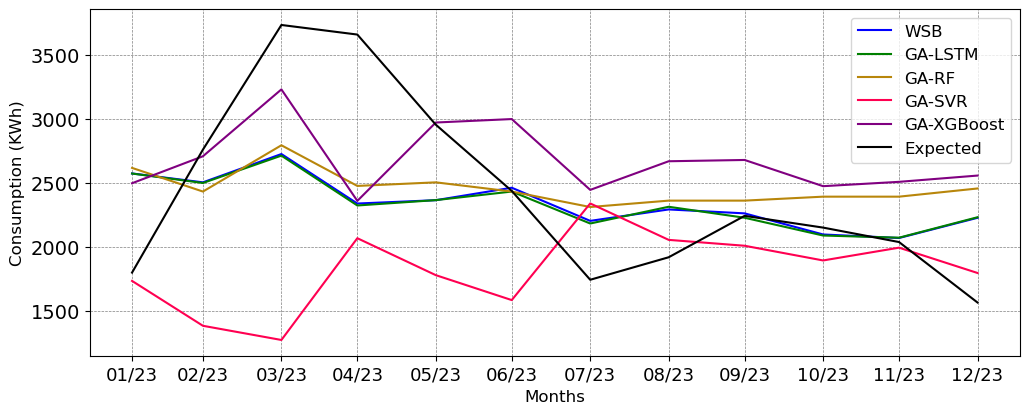

,Booster,CNN,ESN,LSTM,RF,SVR,XGB,Single Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing Additive,Triple Exponential Smoothing Multiplicative,ARIMA
MAE,465.019408,633.166667,529.50,466.916667,529.00,752.50,567.833333,771.365634,1158.57784,867.293643,668.624504,774.485903
sMAPE,18.720000,25.680000,21.92,18.800000,21.57,32.68,23.360000,30.420000,41.59000,33.260000,26.770000,30.470000


In [12]:
plt.figure(figsize=(12, 4.5))
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.prop_cycle'] = plt.cycler(
    color=["blue", "green", "darkgoldenrod", colors.red_rgb, "purple", "cyan", "slategrey", "coral"])

plt.plot(x_test.index, preds_booster, label="WSB")
plt.plot(x_test.index, preds_lstm, label="GA-LSTM")
plt.plot(x_test.index, preds_rf, label="GA-RF")
plt.plot(x_test.index, preds_svr, label="GA-SVR")
plt.plot(x_test.index, preds_xgb, label="GA-XGBoost")
plt.plot(x_test.index, y_test, label="Expected", color="black")

plt.xlabel('Months')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.xticks(x_test.index, x_test.index.strftime("%m/%y"))
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white', )
plt.savefig("results - Coronel 12m/Forecast Results-Coronel.png", bbox_inches='tight')
plt.show()

df_measures = pd.DataFrame(index=["MAE", "sMAPE"], columns=["Booster", "CNN", "ESN", "LSTM", "RF", "SVR", "XGB"])
df_measures["Booster"] = pd.Series(
    [mean_absolute_error(y_test, preds_booster), smape(y_test, preds_booster)],
    index=["MAE", "sMAPE"])
df_measures["CNN"] = pd.Series(
    [mean_absolute_error(y_test, preds_cnn), smape(y_test, preds_cnn)],
    index=["MAE", "sMAPE"])
df_measures["ESN"] = pd.Series(
    [mean_absolute_error(y_test, preds_esn), smape(y_test, preds_esn)],
    index=["MAE", "sMAPE"])
df_measures["LSTM"] = pd.Series(
    [mean_absolute_error(y_test, preds_lstm), smape(y_test, preds_lstm)],
    index=["MAE", "sMAPE"])
df_measures["RF"] = pd.Series([mean_absolute_error(y_test, preds_rf), smape(y_test, preds_rf)],
                              index=["MAE", "sMAPE"])
df_measures["SVR"] = pd.Series(
    [mean_absolute_error(y_test, preds_svr), smape(y_test, preds_svr)], index=["MAE", "sMAPE"])
df_measures["XGB"] = pd.Series(
    [mean_absolute_error(y_test, preds_xgb), smape(y_test, preds_xgb)], index=["MAE", "sMAPE"])
df_measures["Single Exponential Smoothing "] = pd.Series(
    [mean_absolute_error(y_test, preds_single_brown), smape(y_test, preds_single_brown)], index=["MAE", "sMAPE"])
df_measures["Double Exponential Smoothing"] = pd.Series(
    [mean_absolute_error(y_test, preds_double_brown), smape(y_test, preds_double_brown)], index=["MAE", "sMAPE"])
df_measures["Triple Exponential Smoothing Additive"] = pd.Series(
    [mean_absolute_error(y_test, preds_hw_additive), smape(y_test, preds_hw_additive)], index=["MAE", "sMAPE"])
df_measures["Triple Exponential Smoothing Multiplicative"] = pd.Series(
    [mean_absolute_error(y_test, preds_hw_mult), smape(y_test, preds_hw_mult)], index=["MAE", "sMAPE"])
df_measures["ARIMA"] = pd.Series(
    [mean_absolute_error(y_test, preds_arima), smape(y_test, preds_arima)], index=["MAE", "sMAPE"])

df_measures.to_csv(f"results - Coronel 12m/Measures.csv", sep=";", decimal=",", index=True)
df_measures

# SHAP Values - Random Forest

In [8]:
shap.initjs()

explainer_rf = shap.Explainer(rf)
shap_rf = explainer_rf(x_train)

base_values_rf = pd.DataFrame(index=x_train.columns)
values_rf = pd.DataFrame(index=x_train.columns)
data_rf = pd.DataFrame(index=x_train.columns)

for sample in shap_rf:
    base_values_rf = pd.concat([base_values_rf, pd.Series(sample.base_values, index=x_train.columns)], axis=1)
    values_rf = pd.concat([values_rf, pd.Series(sample.values, index=x_train.columns)], axis=1)
    data_rf = pd.concat([data_rf, pd.Series(sample.data, index=x_train.columns)], axis=1)

force = shap.plots.force(base_value=base_values_rf.mean(axis=1).to_numpy(),
                         shap_values=values_rf.mean(axis=1).to_numpy(),
                         text_rotation=90,
                         plot_cmap=["#ff0051", "#3838ff"],
                         features=data_rf.mean(axis=1).to_numpy().astype(int),
                         feature_names=x_train.columns,
                         show=True)
shap.save_html("results - Coronel 12m/SHAPE FORCE RF.html", plot=force, full_html=True)

